加载canada数据集，构建RNN建模的基础数据集，提炼训练集与测试集

In [1]:
import pandas as pd
import numpy as np
src_canada = pd.read_csv("http://image.cador.cn/data/canada.csv")
tmp = src_canada.drop(columns=['year','season'])

# 计算标准化操作对应的均值向量与标准差向量
vmean = tmp.apply(lambda x:np.mean(x))
vstd = tmp.apply(lambda x:np.std(x))

# 对基础数据进行标准化处理
t0 = tmp.apply(lambda x:(x-np.mean(x))/np.std(x)).values

# 定义输入序列长度、输入与输出的维度
SEQLEN = 6
dim_in = 4
dim_out = 4

# 定义训练集与测试集的基础数据，并完成构建。这里使用最后8条数据进行测试
X_train = np.zeros((t0.shape[0]-SEQLEN-8, SEQLEN, dim_in))
Y_train = np.zeros((t0.shape[0]-SEQLEN-8, dim_out),)
X_test = np.zeros((8, SEQLEN, dim_in))
Y_test = np.zeros((8, dim_out),)
for i in range(SEQLEN, t0.shape[0]-8):
    Y_train[i-SEQLEN] = t0[i]
    X_train[i-SEQLEN] = t0[(i-SEQLEN):i]
for i in range(t0.shape[0]-8,t0.shape[0]):
    Y_test[i-t0.shape[0]+8] = t0[i]
    X_test[i-t0.shape[0]+8] = t0[(i-SEQLEN):i]

基于keras构建RNN的网络结构

In [ ]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential
model = Sequential()
model.add(SimpleRNN(128, input_shape=(SEQLEN, dim_in),activation='relu',recurrent_dropout=0.01))
model.add(Dense(dim_out,activation='linear'))
model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop')
history = model.fit(X_train, Y_train, epochs=1000, batch_size=2, validation_split=0)

对后面8条测试数据进行预测，并绘制对比图表

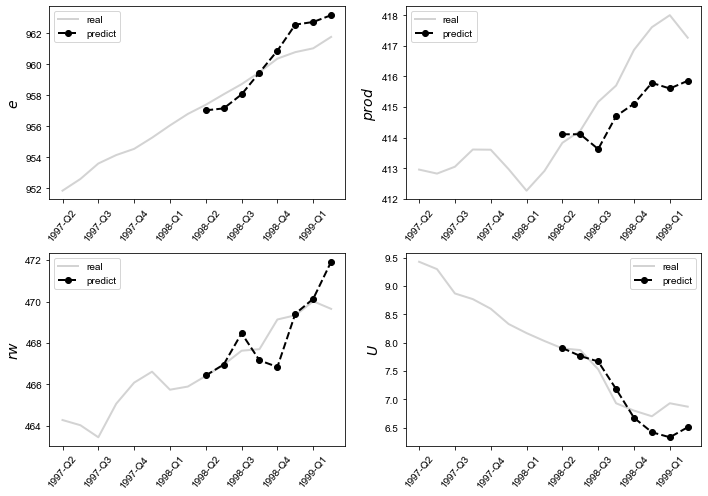

In [4]:
import matplotlib.pyplot as plt
import matplotlib
# 以下 font.family 设置仅适用于 Mac系统，其它系统请使用对应字体名称
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'
preddf=model.predict(X_test)*vstd.values+vmean.values
m = 16
xts = src_canada[['year','season']].iloc[-m:].apply(lambda x:str(x[0])+'-'+x[1],axis=1).values
cols = src_canada.drop(columns=['year','season']).columns
fig, axes = plt.subplots(2,2,figsize=(10,7))
index = 0
for ax in axes.flatten():
    ax.plot(range(m),src_canada[cols].iloc[-m:,index],'-',c='lightgray',linewidth=2,label="real")
    ax.plot(range(m-8,m),preddf[:,index],'o--',c='black',linewidth=2,label="predict")
    ax.set_xticklabels(xts,rotation=50)
    ax.set_ylabel("$"+cols[index]+"$",fontsize=14)
    ax.legend()
    index = index + 1
plt.tight_layout()
plt.show()